# Бета-Банк

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

**Цель проекта:**

    Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. 
    Предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

### Открывавем и и изучаем файл.

In [ ]:
# Импортируем библиотеки pandas
import matplotlib.pyplot as plt
import pandas as pd

# И все используемое далее
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_recall_curve
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle

In [ ]:
# Читаем файл с данными и сохраняем в df
try:
    df = pd.read_csv('/datasets/Churn.csv')
except:
    ! gdown --id "Вырезано цензурой"
    df = pd.read_csv('/content/Churn.csv')

In [ ]:
# переименование столбцов
df.columns = df.columns.str.replace(r"([A-Z])", r" \1").str.lower().str.replace(' ', '_').str[1:]

# Смотрим табличку
display(df.columns)
print()
display(df)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


Index(['row_number', 'customer_id', 'surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited'],
      dtype='object')

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


### Описание данных

Признаки

    • row_number — индекс строки в данных
	• customer_id — уникальный идентификатор клиента
	• surname — фамилия
	• credit_score — кредитный рейтинг
	• geography — страна проживания
	• gender — пол
	• age — возраст
	• tenure — сколько лет человек является клиентом банка
	• balance — баланс на счёте
	• num_of_products — количество продуктов банка, используемых клиентом
	• has_cr_card — наличие кредитной карты
	• isactivemember — активность клиента
	• estimated_salary — предполагаемая зарплата

Целевой признак

	• exited — факт ухода клиента!

In [ ]:
# Табличку к рабочему виду
df_rus = df.rename(columns={'row_number': 'индекс_стр',
                        'customer_id': 'id_клиента',
                        'surname': 'фамилия',
                        'credit_score': 'кред_рейт',
                        'geography': 'страна',
                        'gender': 'пол',
                        'age': 'возраст',
                        'tenure': 'лет_клиент',
                        'balance': 'баланс',
                        'num_of_products': 'кол_прод',
                        'has_cr_card': 'кред_карт',
                        'is_active_member': 'активность',
                        'estimated_salary': 'зарплата',
                        'exited': 'уход'})

display(df_rus)

,индекс_стр,id_клиента,фамилия,кред_рейт,страна,пол,возраст,лет_клиент,баланс,кол_прод,кред_карт,активность,зарплата,уход
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


### Инфо. Пропуски. Describe.

In [ ]:
# Посмотрим заполненость таблицы

# сколько значений и в каком формате
print('\nИнфо:')
print(df_rus.info())

# подсчёт пропусков в долях
print('\nПропусков:')
print(df_rus.isna().mean())

# вдруг чего "на глазок" проявится 
print('\ndescribe:')
display(df_rus.describe())

# проверим дубликаты
print('\nДубликатов =', df_rus.duplicated().sum())


Инфо:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   индекс_стр  10000 non-null  int64  
 1   id_клиента  10000 non-null  int64  
 2   фамилия     10000 non-null  object 
 3   кред_рейт   10000 non-null  int64  
 4   страна      10000 non-null  object 
 5   пол         10000 non-null  object 
 6   возраст     10000 non-null  int64  
 7   лет_клиент  9091 non-null   float64
 8   баланс      10000 non-null  float64
 9   кол_прод    10000 non-null  int64  
 10  кред_карт   10000 non-null  int64  
 11  активность  10000 non-null  int64  
 12  зарплата    10000 non-null  float64
 13  уход        10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB
None

Пропусков:
индекс_стр    0.0000
id_клиента    0.0000
фамилия       0.0000
кред_рейт     0.0000
страна        0.0000
пол           0.0000
возраст       0.0000
лет

,индекс_стр,id_клиента,кред_рейт,возраст,лет_клиент,баланс,кол_прод,кред_карт,активность,зарплата,уход
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000



Дубликатов = 0


##### Вывод

    - Количество записей 10000.
    - С форматом данных все ровно.
    - Есть пропуски в
        - tenure — сколько лет человек является клиентом банка
      Если потребуется удалить строки с пропусками, то 9091 оставшейся будет достаточно для исследования.
    - Дубликатов нет.
    - Разброс параметров и очевидные аномалии оценим в следующем разделе.

### Проверка данных

#### индекс_стр

In [ ]:
display('индекс_стр:', df['row_number'].sort_values().unique())

'индекс_стр:'

array([    1,     2,     3, ...,  9998,  9999, 10000])

#### id_клиента

In [ ]:
display('id_клиента:', df['customer_id'].sort_values().unique())

display('Количество "id_клиента":', len(df['customer_id'].unique()))

'id_клиента:'

array([15565701, 15565706, 15565714, ..., 15815656, 15815660, 15815690])

'Количество "id_клиента":'

10000

#### фамилия

In [ ]:
with pd.option_context('display.max_rows', None):
    display(pd.Series(df['surname'].sort_values().unique()).to_frame().rename(columns={0 : 'фамилия'}))

,фамилия
0,Abazu
1,Abbie
2,Abbott
3,Abdullah
4,Abdulov
5,Abel
6,Abernathy
7,Abramov
8,Abramova
9,Abramovich


#### кред_рейт

In [ ]:
display('кред_рейт:', df['credit_score'].sort_values().unique())

'кред_рейт:'

array([350, 351, 358, 359, 363, 365, 367, 373, 376, 382, 383, 386, 395,
       399, 401, 404, 405, 407, 408, 410, 411, 412, 413, 414, 415, 416,
       417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429,
       430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442,
       443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455,
       456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468,
       469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481,
       482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494,
       495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507,
       508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520,
       521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533,
       534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546,
       547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559,
       560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 57

#### страна

In [ ]:
display('страна:', df['geography'].sort_values().unique())

'страна:'

array(['France', 'Germany', 'Spain'], dtype=object)

#### пол

In [ ]:
display('пол:', df['gender'].sort_values().unique())

'пол:'

array(['Female', 'Male'], dtype=object)

#### возраст

In [ ]:
display('возраст:', df['age'].sort_values().unique())

'возраст:'

array([18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       88, 92])

#### лет_клиент

In [ ]:
display('лет_клиент:', df['tenure'].sort_values().unique())
# Есть пропуски

'лет_клиент:'

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., nan])

#### баланс

In [ ]:
display('баланс:', df['balance'].sort_values().unique())

'баланс:'

array([     0.  ,   3768.69,  12459.19, ..., 222267.63, 238387.56,
       250898.09])

#### кол_прод

In [ ]:
display('кол_прод:', df['num_of_products'].sort_values().unique())

'кол_прод:'

array([1, 2, 3, 4])

#### кред_карт

In [ ]:
display('кред_карт:', df['has_cr_card'].sort_values().unique())

'кред_карт:'

array([0, 1])

#### активность

In [ ]:
display('активность:', df['is_active_member'].sort_values().unique())

'активность:'

array([0, 1])

#### зарплата

In [ ]:
display('зарплата:', df['estimated_salary'].sort_values().unique())

'зарплата:'

array([1.1580000e+01, 9.0070000e+01, 9.1750000e+01, ..., 1.9995333e+05,
       1.9997074e+05, 1.9999248e+05])

#### уход

In [ ]:
display('уход:', df['exited'].sort_values().unique())

'уход:'

array([0, 1])

##### Вывод

    - Аномалий нет.
    - Выбросов и ошибок не наблюдается.
    - Пол и страну лучше перевести в числа, пригодится.
    - Колонку "Фамилия" в признаки не включать.

## Исследование задачи

In [ ]:
# Колонку "Фамилия" в словарик, на всякий случай
surname_ed = df['surname'].unique()
customer_id_ed = df['customer_id'].unique()
surname_dict = dict(zip(surname_ed, customer_id_ed))

# Лишние колонки удаляем
'''
Фамилии ('surname') удаляем, так как это точно дублирует id_клиента ('customer_id').
Остальные признаки определяем по окончании исследования так чтобы это увеличило точность предсказания.
'''
df.pop('surname')
df.pop('row_number')
df.pop('customer_id')
display(df.columns)

Index(['credit_score', 'geography', 'gender', 'age', 'tenure', 'balance',
       'num_of_products', 'has_cr_card', 'is_active_member',
       'estimated_salary', 'exited'],
      dtype='object')

In [ ]:
# Пол и страну переводим в числа
df = pd.get_dummies(df, drop_first=True)

# "Шапку" к стандартному виду
df.columns = df.columns.str.lower()

display(df.columns)
display(df)

Index(['credit_score', 'age', 'tenure', 'balance', 'num_of_products',
       'has_cr_card', 'is_active_member', 'estimated_salary', 'exited',
       'geography_germany', 'geography_spain', 'gender_male'],
      dtype='object')

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_germany,geography_spain,gender_male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5.0,0.00,2,1,0,96270.64,0,0,0,1
9996,516,35,10.0,57369.61,1,1,1,101699.77,0,0,0,1
9997,709,36,7.0,0.00,1,0,1,42085.58,1,0,0,0
9998,772,42,3.0,75075.31,2,1,0,92888.52,1,1,0,1


In [ ]:
# Удаляем nan, а то модели не обучаются
df = df.dropna()

# Добавлено при исследовании моделей.
# Меняем nan, на 0
# df = df.fillna(0)
# df = df.fillna(df['tenure'].median())

print("Сделано!")

Сделано!


### Выделяем признаки

In [ ]:
target = df['exited']
features = df.drop('exited', axis=1)

# Выделаем тестовую выборку
features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            target, 
                                                                            test_size=0.20, 
                                                                            random_state=12345)
# Делим данные тренировочную и валидационную
features_train, features_valid, target_train, target_valid = train_test_split(features_train, 
                                                                              target_train, 
                                                                              test_size=0.25, 
                                                                              random_state=12345)
print('features_train:', len(features_train),'шт')
print('features_valid:', len(features_valid),'шт')
print('features_test:', len(features_test),'шт')

features_train: 5454 шт
features_valid: 1818 шт
features_test: 1819 шт


0    0.796062
1    0.203938
Name: exited, dtype: float64


Text(0.5, 1.0, 'Частоты классов')

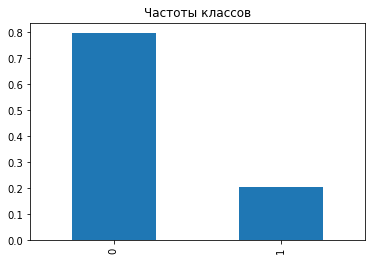

In [ ]:
# А что у нас вообще со значениями в 'exited' (целевом признаке):
class_frequency = df['exited'].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar')
plt.title('Частоты классов')

Виден явный дисбаланс классов в пользу отрицательного класса в соотношении 4:1. Если мы будем всех людей прогнозировать, что они не уйдут из банка, то в 80% случаев мы будем правы.

### DecisionTreeClassifier

Правильность модели:
0.8492849284928493
best_depth 1

Матрица ошибок:
[[1406   46]
 [ 228  138]]

Полнота:
0.3770491803278688

Точность:
0.75

F1-мера:
0.5018181818181818

Частоты классов:
0    0.89879
1    0.10121
dtype: float64

Константная модель:
0.7960620393796062


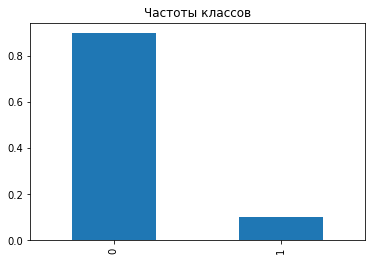

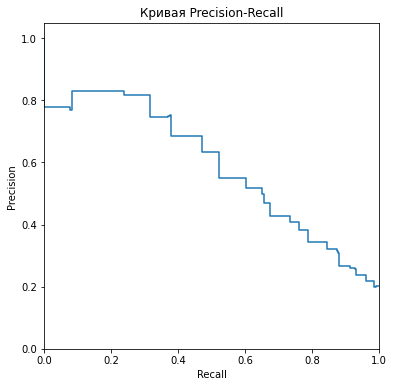

auc_roc_dtс:
0.8175975477577564


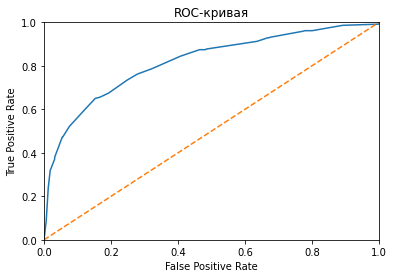

In [ ]:
# _dtс = _DecisionTreeClassifier
best_depth = 0
best_f1_score_dtс = 0
for depth in range(1, 6, 1): # проверялось до 50
    model = DecisionTreeClassifier(random_state=12345, max_depth=6)
    model.fit(features_train, target_train) 
    predicted_valid = model.predict(features_valid)
    f1_score_dtс = f1_score(target_valid, predicted_valid)
    if f1_score_dtс > best_f1_score_dtс:
        best_f1_score_dtс = f1_score_dtс
        best_depth = depth
accuracy_valid_dtс = accuracy_score(target_valid, predicted_valid)
print('\nПравильность модели:')
print(accuracy_valid_dtс)
print('best_depth', best_depth)

print('\nМатрица ошибок:')
print(confusion_matrix(target_valid, predicted_valid))

recall_score_dtс = recall_score(target_valid, predicted_valid)
print('\nПолнота:')
print(recall_score_dtс)

precision_score_dtс = precision_score(target_valid, predicted_valid)
print('\nТочность:')
print(precision_score_dtс)

f1_score_dtс = f1_score(target_valid, predicted_valid)
print('\nF1-мера:')
print(f1_score_dtс)

# Частоты классов в результатах предсказаний решающего дерева.
predicted_valid = pd.Series(model.predict(features_valid))
class_frequency = predicted_valid.value_counts(normalize=True)
print('\nЧастоты классов:')
print(class_frequency)
class_frequency.plot(kind='bar')
plt.title('Частоты классов')

# Константная модель: любому объекту она прогнозирует класс «0».
target_pred_constant = pd.Series(0, index=target.index)
accuracy_score_dtс = accuracy_score(target, target_pred_constant)
print()
print('\nКонстантная модель:')
print(accuracy_score_dtс) 

# PR-кривая
probabilities_valid = model.predict_proba(features_valid)
precision, recall, thresholds = precision_recall_curve(target_valid, probabilities_valid[:, 1])
plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Кривая Precision-Recall')
plt.show()

# AUC-ROC
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc_dtс = roc_auc_score(target_valid, probabilities_one_valid)
print('auc_roc_dtс:')
print(auc_roc_dtс)

# ROC-кривая
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

### LogisticRegression

Правильность модели:
0.7964796479647965

Матрица ошибок:
[[1444    8]
 [ 362    4]]

Полнота:
0.01092896174863388

Точность:
0.3333333333333333

F1-мера:
0.021164021164021163

Частоты классов:
0    0.993399
1    0.006601
dtype: float64

Константная модель:
0.7960620393796062


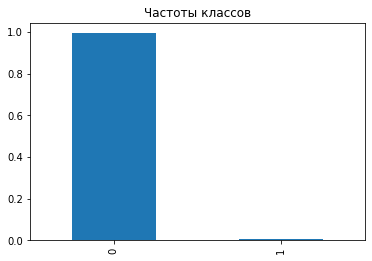

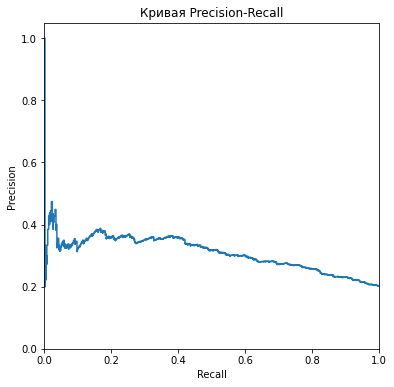

auc_roc_lr:
0.6610968101281067


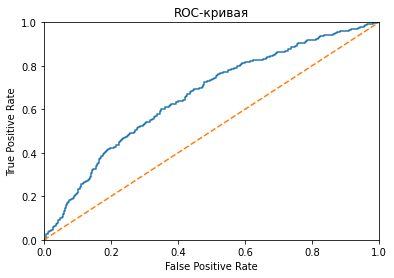

In [ ]:
# _lr = _LogisticRegression
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_train, target_train) 
predicted_valid = model.predict(features_valid)
accuracy_valid_lr = accuracy_score(target_valid, predicted_valid)
print('\nПравильность модели:')
print(accuracy_valid_lr)

print('\nМатрица ошибок:')
print(confusion_matrix(target_valid, predicted_valid))

recall_score_lr = recall_score(target_valid, predicted_valid)
print('\nПолнота:')
print(recall_score_lr)

precision_score_lr = precision_score(target_valid, predicted_valid)
print('\nТочность:')
print(precision_score_lr)

f1_score_lr = f1_score(target_valid, predicted_valid)
print('\nF1-мера:')
print(f1_score_lr)

# Частоты классов в результатах предсказаний решающего дерева.
predicted_valid = pd.Series(model.predict(features_valid))
class_frequency = predicted_valid.value_counts(normalize=True)
print('\nЧастоты классов:')
print(class_frequency)
class_frequency.plot(kind='bar')
plt.title('Частоты классов')

# Константная модель: любому объекту она прогнозирует класс «0».
target_pred_constant = pd.Series(0, index=target.index)
accuracy_score_lr = accuracy_score(target, target_pred_constant)
print('\nКонстантная модель:')
print(accuracy_score_lr) 

# PR-кривая
probabilities_valid = model.predict_proba(features_valid)
precision, recall, thresholds = precision_recall_curve(target_valid, probabilities_valid[:, 1])
plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Кривая Precision-Recall')
plt.show()

# AUC-ROC
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc_lr = roc_auc_score(target_valid, probabilities_one_valid)
print('auc_roc_lr:')
print(auc_roc_lr)

# ROC-кривая
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

### RandomForestRegressor

R2 на обучающей выборке:  0.4744050167804912
R2 на валидационной выборке:  0.3266770907566383

Частоты классов:
0.096214    0.00110
0.814265    0.00055
0.162280    0.00055
0.082416    0.00055
0.073320    0.00055
             ...   
0.193337    0.00055
0.678073    0.00055
0.098180    0.00055
0.362390    0.00055
0.168118    0.00055
Length: 1817, dtype: float64


Константная модель:
0.7960620393796062

auc_roc_rfr_opt:
0.6610968101281067



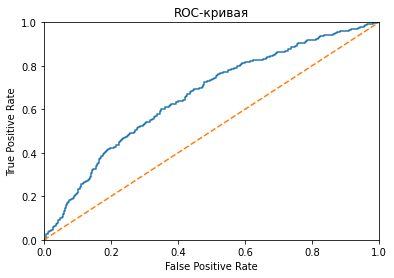

In [ ]:
# _rfr = _RandomForestRegressor
model = RandomForestRegressor(n_estimators=60, max_depth=10, random_state=12345) # выберите наилучшую модель
model.fit(features_train, target_train) # обучите модель на обучающей выборке
predicted_valid = model.predict(features_valid)

'''
# max_depth = range(1, 22, 2), n_estimators = range(100, 1001, 100)

best_est = 0
best_depth = 0
best_r2 = 0
for est in range(10, 1001, 100):
    for depth in range(6, 7, 1):
        model = RandomForestRegressor(n_estimators=est, max_depth=depth, random_state=12345)
        model.fit(features_train, target_train)
        predicted_valid = model.predict(features_valid)
        r2 = model.score(features_valid, target_valid)
        if r2 > best_r2:
            best_r2 = r2
            best_est = est
            best_depth = depth
print("Наилучшая модель")
print("best_est = ", best_est)
print("best_depth = ", best_depth)
print("R2 на обучающей выборке: ", model.score(features_train, target_train))
print("R2 на валидационной выборке: ", model.score(features_valid, target_valid))

'''
model = RandomForestRegressor(n_estimators=410, max_depth=7, random_state=12345)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
result_rfr = model.score(features_valid, target_valid) # считаем качество модели на валидационной выборке
print("R2 на обучающей выборке: ", model.score(features_train, target_train))
print("R2 на валидационной выборке: ", result_rfr)
print()

# Частоты классов в результатах предсказаний решающего дерева.
predicted_valid = pd.Series(model.predict(features_valid))
class_frequency = predicted_valid.value_counts(normalize=True)
print('Частоты классов:')
print(class_frequency)
print()

# Константная модель: любому объекту она прогнозирует класс «0».
target_pred_constant = pd.Series(0, index=target.index)
accuracy_score_rfr = accuracy_score(target, target_pred_constant)
print()
print('Константная модель:')
print(accuracy_score_rfr)
print()

# AUC-ROC
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc_rfr = roc_auc_score(target_valid, probabilities_one_valid)
print('auc_roc_rfr_opt:')
print(auc_roc_rfr)
print()

# ROC-кривая
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

### RandomForestClassifier

Точность модели `Случайный лес`: 0.8591859185918592

Частоты классов:
0.096214    0.00110
0.814265    0.00055
0.162280    0.00055
0.082416    0.00055
0.073320    0.00055
             ...   
0.193337    0.00055
0.678073    0.00055
0.098180    0.00055
0.362390    0.00055
0.168118    0.00055
Length: 1817, dtype: float64


Константная модель:
0.7960620393796062

auc_roc_rfc:
0.6610968101281067



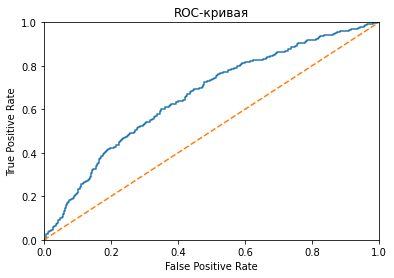

In [ ]:
# _rfc = _RandomForestClassifier

'''
# max_depth = range(1, 22, 2), n_estimators = range(100, 1001, 100)

best_model_rfc = None
best_est_rfc = 0
best_result_rfc = 0
for est in range(100, 1001, 100):
    model_rfc = RandomForestClassifier(n_estimators=est, random_state=12345)
    model_rfc.fit(features_train, target_train)
    result_rfc = model_rfc.score(features_valid, target_valid) # считаем качество модели на валидационной выборке
    if result_rfc > best_result_rfc:
        best_est_rfc = est
        best_model_rfc = model_rfc # сохраняем наилучшую модель
        best_result_rfc = result_rfc #  сохраняем наилучшее значение метрики accuracy на валидационных данных
print("Наилучшая модель")
print("Точность наилучшей модели `Случайный лес`:", best_result_rfc)
print("Лучшая модель:", best_model_rfc)
print("best_est_rfc:", best_est_rfc)
print()
'''

model_rfc = RandomForestClassifier(n_estimators=900, random_state=12345)
model_rfc.fit(features_train, target_train)
result_rfc = model_rfc.score(features_valid, target_valid) # считаем качество модели на валидационной выборке
print("\nТочность модели `Случайный лес`:", result_rfc)

# Частоты классов в результатах предсказаний решающего дерева.
predicted_valid = pd.Series(model.predict(features_valid))
class_frequency = predicted_valid.value_counts(normalize=True)
print('\nЧастоты классов:')
print(class_frequency)

# Константная модель: любому объекту она прогнозирует класс «0».
target_pred_constant = pd.Series(0, index=target.index)
accuracy_score_rfc = accuracy_score(target, target_pred_constant)
print('\nКонстантная модель:')
print(accuracy_score_rfc)

# AUC-ROC
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc_rfc = roc_auc_score(target_valid, probabilities_one_valid)
print('\nauc_roc_rfc:')
print(auc_roc_rfc)
print()

# ROC-кривая
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

##### Вывод

    - Правильность модели максимальной получилась в RandomForestClassifier.
    - Удаление из признаков колонок с фамилиями и номерами строк повысило точность прогноза.
    - Не удалось достичь F1-меры не менее 0.59

In [ ]:
# Все посчитанное собираем в табличку
Name = ['Правильность модели', 'Полнота', 'Точность', 'F1-мера', 'AUC-ROC', 'Константная модель'] 
dtс = [accuracy_valid_dtс, recall_score_dtс, precision_score_dtс, f1_score_dtс, auc_roc_dtс, accuracy_score_dtс]
lr = [accuracy_valid_lr, recall_score_lr, precision_score_lr, f1_score_lr, auc_roc_lr, accuracy_score_lr]
rfr = [result_rfr, 'Нет', 'Нет', 'Нет', auc_roc_rfr, accuracy_score_rfr]
rfс = [result_rfc, 'Нет', 'Нет', 'Нет', auc_roc_rfc, accuracy_score_rfc]
list_tuples = list(zip(Name, dtс, lr, rfr, rfс)) 
dframe = pd.DataFrame(list_tuples, columns=['Name', 'dtс', 'lr', 'rfr', 'rfс']) 
dframe

,Name,dtс,lr,rfr,rfс
0,Правильность модели,0.849285,0.796480,0.326677,0.859186
1,Полнота,0.377049,0.010929,Нет,Нет
2,Точность,0.750000,0.333333,Нет,Нет
3,F1-мера,0.501818,0.021164,Нет,Нет
4,AUC-ROC,0.817598,0.661097,0.661097,0.661097
5,Константная модель,0.796062,0.796062,0.796062,0.796062


## Борьба с дисбалансом

### Масштабируем признаки

In [ ]:
'''
Масштабирование улучшило точность предсказания.
Если его выполнить сразу после разбиения данных, то это не изменит результаты 
по оптимизированным данным, но уменьшит наглядность изменений происходящих после 
оптимизации.
'''
# Чтобы предупреждение не появлялось: 
pd.options.mode.chained_assignment = None

# Масштабируем признаки:
numeric = [#'customer_id', 
           'credit_score', 
           'tenure', 'balance', 
           'num_of_products', 
           'estimated_salary']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
print(features_train.head(5))


      credit_score  age    tenure   balance  num_of_products  has_cr_card  \
3706     -0.203819   44  0.352316  0.786022         0.782369            0   
6805     -0.357513   35 -1.373506 -1.230577         0.782369            1   
4449      0.175290   36 -0.683177 -1.230577         0.782369            1   
598       0.349476   57  0.007151  1.379462        -0.914942            0   
1845      0.902771   36  1.387809 -1.230577        -0.914942            0   

      is_active_member  estimated_salary  geography_germany  geography_spain  \
3706                 0         -0.357205                  0                1   
6805                 1         -1.671048                  0                0   
4449                 0         -1.119181                  0                0   
598                  0         -1.569064                  1                0   
1845                 1          1.543790                  0                0   

      gender_male  
3706            0  
6805            

### Увеличиваем выборку

In [ ]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    return features_upsampled, target_upsampled
features_upsampled, target_upsampled = upsample(features_train, target_train, 3)
features_train = features_upsampled
target_train = target_upsampled
print("Сделано!")

Сделано!


### Уменьшаем выборки

In [ ]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)
features_train = features_downsampled
target_train = target_downsampled
print("Сделано!")

Сделано!


Этот раздел уменьшает правильность предсказания и F1-метрику.

Правильность модели RandomForestRegressor ушла в минус.

### DecisionTreeClassifier

Правильность модели:
0.7161716171617162
best_depth 17

Матрица ошибок:
[[1048  404]
 [ 112  254]]

Полнота:
0.6939890710382514

Точность:
0.3860182370820669

F1-мера:
0.49609375

Частоты классов:
0    0.638064
1    0.361936
dtype: float64

Константная модель:
0.7960620393796062


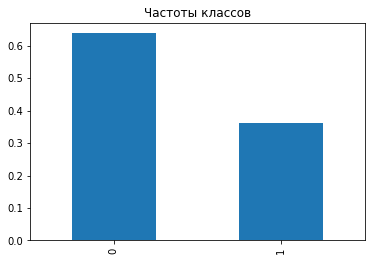

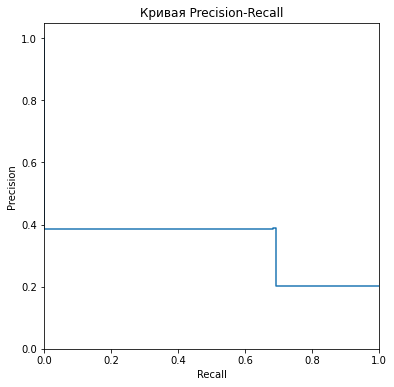

auc_roc_dtс_opt:
0.7080510770898252


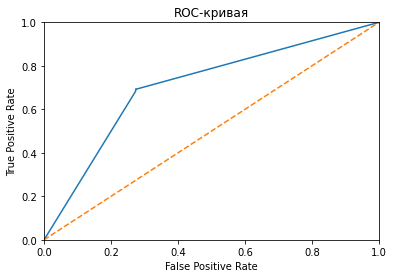

In [ ]:
# _dtс_opt = _DecisionTreeClassifier_optimized
best_depth = 0
best_f1_score_dtс = 0
for depth in range(17, 18, 1): # проверялось до 50
    model = DecisionTreeClassifier(random_state=12345, max_depth=17)
    model.fit(features_train, target_train) 
    predicted_valid = model.predict(features_valid)
    f1_score_dtс = f1_score(target_valid, predicted_valid)
    if f1_score_dtс > best_f1_score_dtс:
        best_f1_score_dtс = f1_score_dtс
        best_depth = depth
accuracy_valid_dtс_opt = accuracy_score(target_valid, predicted_valid)
print('\nПравильность модели:')
print(accuracy_valid_dtс_opt)
print('best_depth', best_depth)

print('\nМатрица ошибок:')
print(confusion_matrix(target_valid, predicted_valid))

recall_score_dtс_opt = recall_score(target_valid, predicted_valid)
print('\nПолнота:')
print(recall_score_dtс_opt)

precision_score_dtс_opt = precision_score(target_valid, predicted_valid)
print('\nТочность:')
print(precision_score_dtс_opt)

f1_score_dtс_opt = f1_score(target_valid, predicted_valid)
print('\nF1-мера:')
print(f1_score_dtс_opt)

# Частоты классов в результатах предсказаний решающего дерева.
predicted_valid = pd.Series(model.predict(features_valid))
class_frequency = predicted_valid.value_counts(normalize=True)
print('\nЧастоты классов:')
print(class_frequency)
class_frequency.plot(kind='bar')
plt.title('Частоты классов')

# Константная модель: любому объекту она прогнозирует класс «0».
target_pred_constant = pd.Series(0, index=target.index)
accuracy_score_dtс_opt = accuracy_score(target, target_pred_constant)
print('\nКонстантная модель:')
print(accuracy_score_dtс_opt) 

# PR-кривая
probabilities_valid = model.predict_proba(features_valid)
precision, recall, thresholds = precision_recall_curve(target_valid, probabilities_valid[:, 1])
plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Кривая Precision-Recall')
plt.show()

# AUC-ROC
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc_dtс_opt = roc_auc_score(target_valid, probabilities_one_valid)
print('auc_roc_dtс_opt:')
print(auc_roc_dtс_opt)

# ROC-кривая
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

### LogisticRegression

Правильность модели:
0.4064906490649065

Матрица ошибок:
[[ 390 1062]
 [  17  349]]

Полнота:
0.953551912568306

Точность:
0.24734231041814317

F1-мера:
0.3927968486212718

Частоты классов:
1    0.776128
0    0.223872
dtype: float64

Константная модель:
0.7960620393796062


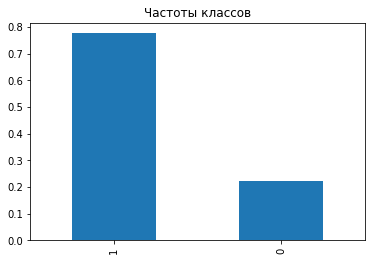

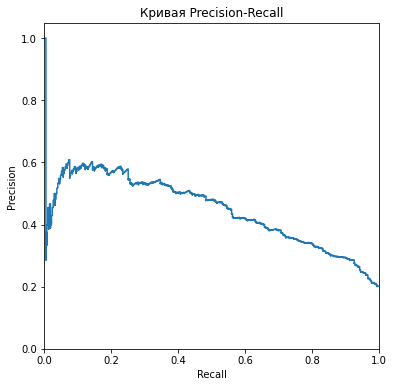

auc_roc_lr_opt:
0.7733106022971896


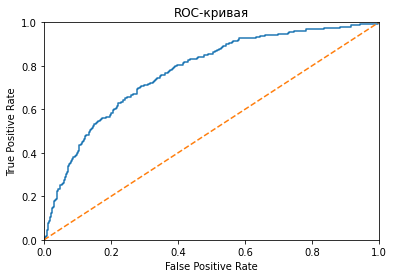

In [ ]:
# _lr_opt = _LogisticRegression_optimized
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_train, target_train) 
predicted_valid = model.predict(features_valid)
accuracy_valid_lr_opt = accuracy_score(target_valid, predicted_valid)
print('\nПравильность модели:')
print(accuracy_valid_lr_opt)

print('\nМатрица ошибок:')
print(confusion_matrix(target_valid, predicted_valid))

recall_score_lr_opt = recall_score(target_valid, predicted_valid)
print('\nПолнота:')
print(recall_score_lr_opt)

precision_score_lr_opt = precision_score(target_valid, predicted_valid)
print('\nТочность:')
print(precision_score_lr_opt)

f1_score_lr_opt = f1_score(target_valid, predicted_valid)
print('\nF1-мера:')
print(f1_score_lr_opt)

# Частоты классов в результатах предсказаний решающего дерева.
predicted_valid = pd.Series(model.predict(features_valid))
class_frequency = predicted_valid.value_counts(normalize=True)
print('\nЧастоты классов:')
print(class_frequency)
class_frequency.plot(kind='bar')
plt.title('Частоты классов')

# Константная модель: любому объекту она прогнозирует класс «0».
target_pred_constant = pd.Series(0, index=target.index)
accuracy_score_lr_opt = accuracy_score(target, target_pred_constant)
print('\nКонстантная модель:')
print(accuracy_score_lr_opt) 

# PR-кривая
probabilities_valid = model.predict_proba(features_valid)
precision, recall, thresholds = precision_recall_curve(target_valid, probabilities_valid[:, 1])
plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Кривая Precision-Recall')
plt.show()

# AUC-ROC
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc_lr_opt = roc_auc_score(target_valid, probabilities_one_valid)
print('auc_roc_lr_opt:')
print(auc_roc_lr_opt)

# ROC-кривая
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

### RandomForestRegressor

R2 на обучающей выборке:  0.53927647979904
R2 на валидационной выборке:  -0.5962983463032452

Частоты классов:
1.000000    0.00165
0.058543    0.00110
0.985000    0.00110
0.810977    0.00055
0.961822    0.00055
             ...   
0.975642    0.00055
0.604038    0.00055
0.887084    0.00055
0.312929    0.00055
0.722355    0.00055
Length: 1814, dtype: float64


Константная модель:
0.7960620393796062

auc_roc_rfr_opt:
0.7733106022971896



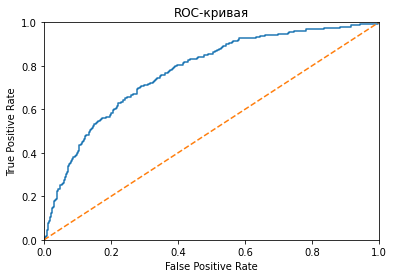

In [ ]:
# _rfr_opt = _RandomForestRegressor_optimized

'''
# max_depth = range(1, 22, 2), n_estimators = range(100, 1001, 100)

best_est = 0
best_depth = 0
best_r2 = 0
for est in range(100, 1001, 100):
    for depth in range(6, 7, 1):
        model = RandomForestRegressor(n_estimators=est, max_depth=depth, random_state=12345)
        model.fit(features_train, target_train)
        predicted_valid = model.predict(features_valid)
        r2 = model.score(features_valid, target_valid)
        if r2 > best_r2:
            best_r2 = r2
            best_est = est
            best_depth = depth
print("Наилучшая модель")
print("best_est = ", best_est)
print("best_depth = ", best_depth)
print("R2 на обучающей выборке: ", model.score(features_train, target_train))
print("R2 на валидационной выборке: ", model.score(features_valid, target_valid))

'''
model = RandomForestRegressor(n_estimators=400, max_depth=7, random_state=12345)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
result_rfr_opt = model.score(features_valid, target_valid) # считаем качество модели на валидационной выборке
print("R2 на обучающей выборке: ", model.score(features_train, target_train))
print("R2 на валидационной выборке: ", result_rfr_opt)
print()

# Частоты классов в результатах предсказаний решающего дерева.
predicted_valid = pd.Series(model.predict(features_valid))
class_frequency = predicted_valid.value_counts(normalize=True)
print('Частоты классов:')
print(class_frequency)
print()

# Константная модель: любому объекту она прогнозирует класс «0».
target_pred_constant = pd.Series(0, index=target.index)
accuracy_score_rfr_opt = accuracy_score(target, target_pred_constant)
print()
print('Константная модель:')
print(accuracy_score_rfr_opt)
print()

# AUC-ROC
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc_rfr_opt = roc_auc_score(target_valid, probabilities_one_valid)
print('auc_roc_rfr_opt:')
print(auc_roc_rfr_opt)
print()

# ROC-кривая
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()


### RandomForestClassifier

Точность модели `Случайный лес`: 0.7227722772277227

Частоты классов:
1.000000    0.00165
0.058543    0.00110
0.985000    0.00110
0.810977    0.00055
0.961822    0.00055
             ...   
0.975642    0.00055
0.604038    0.00055
0.887084    0.00055
0.312929    0.00055
0.722355    0.00055
Length: 1814, dtype: float64


Константная модель:
0.7960620393796062

auc_roc_rfr_opt:
0.7733106022971896



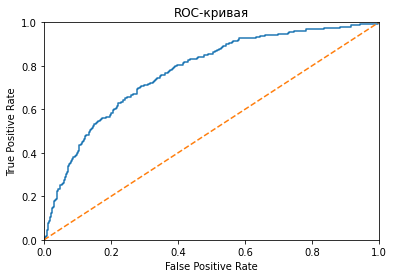

In [ ]:
# _rfc_opt = _RandomForestClassifier_optimized

'''
# max_depth = range(1, 22, 2), n_estimators = range(100, 1001, 100)

best_model_rfc_opt = None
best_est_rfc_opt = 0
best_result_rfc_opt = 0
for est in range(100, 1001, 100):
    model_rfc_opt = RandomForestClassifier(n_estimators=est, random_state=12345)
    model_rfc_opt.fit(features_train, target_train)
    result = model_rfc_opt.score(features_valid, target_valid) # считаем качество модели на валидационной выборке
    if result > best_result_rfc_opt:
        best_est_rfc_opt = est
        best_model_rfc_opt = model_rfc_opt # сохраняем наилучшую модель
        best_result_rfc_opt = result #  сохраняем наилучшее значение метрики accuracy на валидационных данных
print("Наилучшая модель")
print("Точность наилучшей модели `Случайный лес`:", best_result_rfc_opt)
print("Лучшая модель:", best_model_rfc_opt)
print()
'''

model_rfc_opt = RandomForestClassifier(n_estimators=900, random_state=12345)
model_rfc_opt.fit(features_train, target_train)
result_rfc_opt = model_rfc_opt.score(features_valid, target_valid) # считаем качество модели на валидационной выборке
print("Точность модели `Случайный лес`:", result_rfc_opt)
print()

# Частоты классов в результатах предсказаний решающего дерева.
predicted_valid = pd.Series(model.predict(features_valid))
class_frequency = predicted_valid.value_counts(normalize=True)
print('Частоты классов:')
print(class_frequency)
print()

# Константная модель: любому объекту она прогнозирует класс «0».
target_pred_constant = pd.Series(0, index=target.index)
accuracy_score_rfc_opt = accuracy_score(target, target_pred_constant)
print()
print('Константная модель:')
print(accuracy_score_rfc_opt)
print()

# AUC-ROC
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc_rfc_opt = roc_auc_score(target_valid, probabilities_one_valid)
print('auc_roc_rfr_opt:')
print(auc_roc_rfc_opt)
print()

# ROC-кривая
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()


##### Вывод

    - Увеличение выборки позволило увеличить точность прогноза.
    - Уменьшение выборки только уменьшало точность прогноза.
    - Правильность предсказания у модели RandomForestClassifier_optimized получилась максимальной.
    - Максимальную F1-меру удалось получить только 0.46 в DecisionTreeClassifier и DecisionTreeClassifier_optimized.

In [ ]:
# Табличка с результатами расчетов
Name = ['Правильность модели', 'Полнота', 'Точность', 'F1-мера', 'AUC-ROC', 'Константная модель'] 
dtс = [accuracy_valid_dtс, recall_score_dtс, precision_score_dtс, f1_score_dtс, auc_roc_dtс, accuracy_score_dtс]
dtс_opt = [accuracy_valid_dtс_opt, recall_score_dtс_opt, precision_score_dtс_opt, f1_score_dtс_opt, auc_roc_dtс_opt, accuracy_score_dtс_opt]
lr = [accuracy_valid_lr, recall_score_lr, precision_score_lr, f1_score_lr, auc_roc_lr, accuracy_score_lr]
lr_opt = [accuracy_valid_lr_opt, recall_score_lr_opt, precision_score_lr_opt, f1_score_lr_opt, auc_roc_lr_opt, accuracy_score_lr_opt]
rfr = [result_rfr, 'Нет', 'Нет', 'Нет', auc_roc_rfr, accuracy_score_rfr]
rfr_opt = [result_rfr_opt, 'Нет', 'Нет', 'Нет', auc_roc_rfr_opt, accuracy_score_rfr_opt]
rfc = [result_rfc, 'Нет', 'Нет', 'Нет', auc_roc_rfc, accuracy_score_rfc]
rfc_opt = [result_rfc_opt, 'Нет', 'Нет', 'Нет', auc_roc_rfc_opt, accuracy_score_rfc_opt]
list_tuples = list(zip(Name, dtс, dtс_opt, lr, lr_opt, rfr, rfr_opt, rfc, rfc_opt)) 
dframe = pd.DataFrame(list_tuples, columns=['Name', 'dtс', 'dtс_opt', 'lr', 'lr_opt', 'rfr', 'rfr_opt', 'rfc', 'rfc_opt']) 
dframe

,Name,dtс,dtс_opt,lr,lr_opt,rfr,rfr_opt,rfc,rfc_opt
0,Правильность модели,0.849285,0.716172,0.796480,0.406491,0.326677,-0.596298,0.859186,0.722772
1,Полнота,0.377049,0.693989,0.010929,0.953552,Нет,Нет,Нет,Нет
2,Точность,0.750000,0.386018,0.333333,0.247342,Нет,Нет,Нет,Нет
3,F1-мера,0.496094,0.496094,0.021164,0.392797,Нет,Нет,Нет,Нет
4,AUC-ROC,0.817598,0.708051,0.661097,0.773311,0.661097,0.773311,0.661097,0.773311
5,Константная модель,0.796062,0.796062,0.796062,0.796062,0.796062,0.796062,0.796062,0.796062


## Тестирование модели

Для тестирования выбираем модель с наибольшим AUC-ROC = 0.817598.

In [ ]:
# _dtс = _DecisionTreeClassifier
model = DecisionTreeClassifier(random_state=12345, max_depth=6)
model.fit(features_train, target_train) 
predicted_test = model.predict(features_test)
f1_score_dtс_test = f1_score(target_test, predicted_test)
print('f1_score_dtс_val:', f1_score_dtс)
print('f1_score_dtс_test:', f1_score_dtс_test)
print()

f1_score_dtс_val: 0.49609375
f1_score_dtс_test: 0.31631135349529005



##### Вывод общий

    - Правильность модели максимальной получилась в RandomForestClassifier.
    - Удаление из признаков колонок с фамилиями и номерами строк повысило точность прогноза.
    - Не удалось достичь F1-меры не менее 0.59.
      Но лучшей по ней оказалась модель DecisionTreeClassifier.
    - На тестовой выборке F1-мера уменьшилась.